In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import torch
import torch.nn as nn
import torch_geometric as pyg
import torch_geometric.nn as gnn

/mnt/c/Users/nck/repos/GNN-Plus/env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set_style('darkgrid')
np.random.seed(42)

# Dataset

In [3]:
# Get graph
data_folder = './data/training_matrices_DGL/'
mat = pd.read_csv(data_folder + 'Endothelial.feat.mat', index_col=0, sep='\t')
genes = np.array(mat.columns)
assert (genes == np.array(mat.index)).all()

# Get labels
meta = pd.read_csv(data_folder + 'training_labels.txt', index_col=0, sep='\t')
labels = meta.values[:, 0]
labels = np.array([str(meta.loc[g]['label']) if g in meta.index else 'unknown' for g in genes])

### SUBSET
# subset_idx = np.random.choice(len(labels), 1000, replace=False)
ad_labels = np.argwhere(labels == 'AD').flatten()
notad_labels = np.argwhere(labels == 'notAD').flatten()
unknown_labels = np.argwhere(labels == 'unknown').flatten()
subset_idx = np.concatenate([
    np.random.choice(ad_labels, 100, replace=False),
    np.random.choice(notad_labels, 500, replace=False),
    np.random.choice(unknown_labels, 500, replace=False)])
mat = mat.iloc[subset_idx, subset_idx]
genes = genes[subset_idx]
labels = labels[subset_idx]
###

# Sort labels
ad_labels = np.argwhere(labels == 'AD').flatten()
notad_labels = np.argwhere(labels == 'notAD').flatten()
unknown_labels = np.argwhere(labels == 'unknown').flatten()
known_labels = np.array(list(set(range(len(genes))) - set(unknown_labels)))

# Split into training and testing
train_num = int(len(genes) * .8)
val_num = len(genes) - train_num
train_idx = np.random.choice(len(genes), train_num, replace=False)
val_idx = np.array(list(set(range(len(genes))) - set(train_idx)))

# Masks
train_mask = [i in train_idx for i in range(len(genes))]
val_mask = [i in val_idx for i in range(len(genes))]

# Format sparse
mat.values[np.eye(mat.values.shape[0] ,dtype=bool)] = 0  # Remove diagonal
mat = scipy.sparse.coo_matrix(mat.values)
edge_indices = np.stack([mat.row, mat.col])
edge_indices = np.concatenate([edge_indices, edge_indices[::-1]], axis=1)  # Make undirected
edge_weights = mat.data

# Construct dataset
data = pyg.data.Data(
    y=labels,
    edge_index=torch.tensor(edge_indices).to(torch.int64),
    edge_attributes=torch.tensor(edge_weights).to(torch.float64),
    train_mask=train_mask,
    val_mask=val_mask)
data

# Example dataset
# from torch_geometric.datasets import Planetoid
# dataset = Planetoid('./data', 'Cora')[0]
# dataset
# row, col = data.edge_index
# print(col.dtype)
# row, col = dataset.edge_index
# print(col.dtype)

Data(edge_index=[2, 1329792], y=[1100], edge_attributes=[664896], train_mask=[1100], val_mask=[1100])

In [4]:
# islands = []
# for node_idx in range(len(data.y)):
#     found = False
#     for e in data.edge_index.T:
#         if node_idx in e:
#             neighbor_idx = int(e[np.argwhere(e != node_idx)][0, 0])
#             for island_idx, island in enumerate(islands):
#                 if neighbor_idx in island:
#                     island.add(node_idx)
#                     found = True
#                     break
#         if found:
#             break
#     else:  # On completion without break
#         islands.append({node_idx})
# print(f'There are {len(islands)} disconnected subgraphs')
# for island in islands:
#     print(island)
## There are 8 disconnected subgraphs

# Embedding Model

In [5]:
embedding_dim = 16

In [6]:
# Create model
model = gnn.Node2Vec(
    data.edge_index,
    embedding_dim=embedding_dim,
    walk_length=20,
    context_size=10,
    walks_per_node=10,
    num_negative_samples=1,
    p=1,
    q=1,
    num_nodes=len(data.y),
    sparse=True)

loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(model.parameters(), lr=1e-2)  # LR

In [7]:
# Train model
model.train()

def train():
    epoch_loss = 0
    for pos, neg in loader:
        loss = model.loss(pos, neg)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach()
    return epoch_loss / len(loader)

for i in range(11):
    epoch_loss = train()
    if i % 2 == 0:
        print(f'Epoch {i} Loss: {epoch_loss:.3f}')
model.eval();

Epoch 0 Loss: 3.342
Epoch 2 Loss: 2.601
Epoch 4 Loss: 2.042
Epoch 6 Loss: 1.715
Epoch 8 Loss: 1.565
Epoch 10 Loss: 1.522


# AD Prediction

In [8]:
# Create model
class FCL(nn.Module):
    def __init__(self, input_dim, output_dim=1):
        super().__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.fcl = nn.Linear(self.input_dim, self.output_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, X):
        return self.sigmoid(self.fcl(X))
    
ad_model = FCL(embedding_dim)
ad_optimizer = torch.optim.Adam(ad_model.parameters(), lr=1e-2)
ad_criterion = nn.MSELoss()

In [9]:
# Train model
batch_size = 128
batches = data.edge_index.shape[1] // batch_size
z = model()
ad_model.train()
for i in range(61):
    epoch_loss = 0
    for j in range(batches):
        seg_size = int(batch_size / 2)
        ad_batch_idx = np.random.choice(np.intersect1d(ad_labels, train_idx), seg_size, replace=True)
        notad_batch_idx = np.random.choice(np.intersect1d(notad_labels, train_idx), seg_size, replace=True)
        batch_idx = np.concatenate([ad_batch_idx, notad_batch_idx])
        
        true = torch.cat([torch.ones((seg_size, 1)), torch.zeros((seg_size, 1))])
        logits = ad_model(z[batch_idx])
        loss = ad_criterion(logits, true)
        loss.backward()
        ad_optimizer.step()
        epoch_loss += loss.detach()
    epoch_loss /= batches
    if i % 10 == 0:
        print(f'Epoch {i} Loss: {epoch_loss:.3f}')
ad_model.eval();

Epoch 0 Loss: 0.341
Epoch 10 Loss: 0.323
Epoch 20 Loss: 0.323
Epoch 30 Loss: 0.322
Epoch 40 Loss: 0.321
Epoch 50 Loss: 0.322
Epoch 60 Loss: 0.321


# Results

In [10]:
# Predictions
pred_val = ad_model(model())
pred = np.array(['AD' if ad else 'notAD' for ad in (pred_val > .5)])

# Printout
print('GENE\tPRED\tVALUE\tTRUE')
for i in np.random.choice(np.intersect1d(ad_labels, val_idx), 10, replace=True):
    print(f'{genes[i]}\t{pred[i]}\t{float(pred_val[i].detach()):.3f}\tAD')
print()
print('GENE\tPRED\tVALUE\tTRUE')
for i in np.random.choice(np.intersect1d(notad_labels, val_idx), 10, replace=True):
    print(f'{genes[i]}\t{pred[i]}\t{float(pred_val[i].detach()):.3f}\tnotAD')
print()
print('GENE\tPRED\tVALUE\tTRUE')
for i in np.random.choice(unknown_labels, 10, replace=True):
    print(f'{genes[i]}\t{pred[i]}\t{float(pred_val[i].detach()):.3f}\tunknown')

# Write enrichment genes to files
ad_enrichment = genes[np.intersect1d(np.argwhere(pred == 'AD'), val_idx)]
notad_enrichment = genes[np.intersect1d(np.argwhere(pred == 'notAD'), val_idx)]
np.savetxt('AD.txt', ad_enrichment, fmt='%s')
np.savetxt('notAD.txt', notad_enrichment, fmt='%s')

GENE	PRED	VALUE	TRUE
AMFR	AD	1.000	AD
IKBKB	AD	1.000	AD
IRS1	notAD	0.000	AD
PPARGC1A	AD	1.000	AD
AMFR	AD	1.000	AD
IKBKB	AD	1.000	AD
PPARGC1A	AD	1.000	AD
PPARG	AD	1.000	AD
CIB1	AD	1.000	AD
MME	AD	1.000	AD

GENE	PRED	VALUE	TRUE
FPR3	notAD	0.000	notAD
SLCO2A1	notAD	0.000	notAD
GIP	AD	1.000	notAD
GEM	notAD	0.000	notAD
UHRF1	notAD	0.000	notAD
CLTA	AD	1.000	notAD
EIF4B	AD	1.000	notAD
TNFRSF25	notAD	0.000	notAD
WNT5B	AD	1.000	notAD
C1QL3	AD	1.000	notAD

GENE	PRED	VALUE	TRUE
DKK2	AD	1.000	unknown
PAN2	notAD	0.000	unknown
IGDCC4	AD	1.000	unknown
HVCN1	AD	1.000	unknown
GLRA1	AD	1.000	unknown
GIMAP2	AD	1.000	unknown
KLF9	AD	1.000	unknown
TRAPPC2L	AD	1.000	unknown
OR52A5	AD	1.000	unknown
ABI2	notAD	0.000	unknown


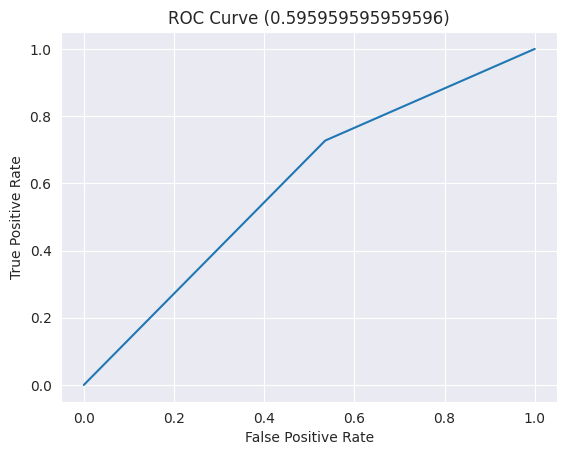

In [11]:
# ROC Curve
eval_idx = np.intersect1d(val_idx, known_labels)
fpr, tpr, thresholds = roc_curve(1.*(labels[eval_idx] == 'AD'), pred_val[eval_idx].detach())
plt.plot(fpr, tpr)
plt.title(f'ROC Curve ({auc(fpr, tpr)})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');